In [5]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rand
import scipy.optimize
from scipy import stats

In [6]:
EXPECTED_AREA = 1.506484

In [7]:
def mandelbrot(xmin, xmax, ymin, ymax, xiter, yiter, limit):
    a_step = 0

    pixel_list = np.ndarray((xiter + 2, yiter + 2))

    for a in np.linspace(xmin, xmax, xiter):
        a_step += 1
        b_step = 0
        for b in np.linspace(ymin, ymax, yiter):
            b_step += 1
            z_0 = complex(a, b)
            z = z_0
            counter = 0

            while abs(z) < 2 and counter < limit:
                z = z ** 2 + z_0
                counter += 1
                
            pixel_list[b_step][a_step] = counter
    

    return pixel_list



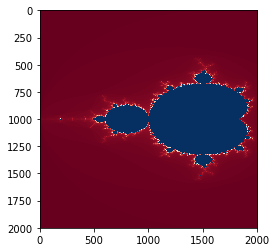

In [8]:
def plot_maker():
    
    a_step = -1
    b_step = -1
    xmin = -2
    xmax = 0.5
    ymin = -2
    ymax = 2
    xiter = 2000
    yiter = 2000
    limit = 250

    pixel_list = np.zeros((xiter+1, yiter+1))

    for a in np.linspace(xmin, xmax, xiter):
        a_step += 1
        b_step = 0
        for b in np.linspace(ymin, ymax, yiter):
            b_step += 1
            z_0 = complex(a, b)
            z = z_0
            counter = 0

            while abs(z) < 2 and counter < 250:
                z = z ** 2 + z_0
                counter += 1
                
            pixel_list[b_step][a_step] = counter

    plt.imshow(pixel_list, cmap='RdBu')
    plt.show()

plot_maker()
    

    

In [9]:
xmin = -2
xmax = 0.5
ymin = -2
ymax = 2
xiter = 2000
yiter = 2000
limit = 250

pixel_list = mandelbrot(xmin, xmax, ymin, ymax, xiter, yiter, limit)


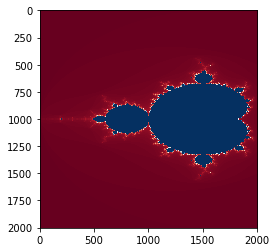

In [10]:
%matplotlib inline
plt.imshow(pixel_list, cmap='RdBu')
plt.show()


In [11]:
def check_converge(z_0, treshold=2, max_iterations=25):
    """
    Checks if the complex number z_0 converges within the max_iterations.
    """

    z = z_0
    counter = 0
    while True:
        z = z ** 2 + z_0
        counter += 1

        if abs(z) > 2:
            return False
        if counter > max_iterations:
            return True

def determine_area(i = 25, s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2, sample_method="pure"):
    """
    Determine the area of the mandelbrot set.

    Parameters:
    i: int, Max number of iterations
    s: int, The number of sample points.
    sample_method: string, options are:
        'pure': pure random sampling,
        'hypercube': hypercube sampling,
        'orthogonal': orthogonal sampling
    """
    
    bounding_box_area = (xmax - xmin) * (ymax - ymin)

    if sample_method == "pure":
        Z = generate_sample_points_pure_random(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    elif sample_method == "hypercube":
        Z = generate_sample_points_hypercube(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    elif sample_method == "orthogonal":
        Z = generate_sample_points_orthogonal(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

    Z0 = Z

    N = np.zeros(s)

    for _ in range(i):
        Z = np.where(abs(Z) < 2, Z ** 2 + Z0, 100)

    N[Z != 100] = 1

    n_good_points = sum(N)
    
    return bounding_box_area * (n_good_points / s)

def plot_i_s_contour(i_list, s_list, log=False):
    """
    Plots the difference between the expected and calculated area for different values for i and s. 
    i is the maximum number of iterations and s is the number of samples. 
    """

    total_evaluations = len(i_list) * len(s_list)
    n_evaluations = 0

    expected_area = 1.506484

    data = []
    for i in i_list:

        results = []
        for s in s_list:
            results.append(determine_area(i=i, s=s) - expected_area)
            n_evaluations += 1

            if log and n_evaluations % 10 == 0:
                print(f"Progress: {n_evaluations/total_evaluations * 100:0f}%", end="\r")
        
        data.append(results)

    contour = plt.contourf(s_list, i_list, data, 10, cmap="PuBuGn_r")
    
    colorbar = plt.colorbar(contour)
    colorbar.set_label("Difference between expected area")

    plt.xlabel("Samples")
    plt.ylabel("Max iterations")

    plt.xscale("log")
    plt.yscale("log")
    plt.show()

def plot_i_s_variance(i_list, s_list, nruns=10, log=False):
    """
    Plots the variance of the difference between the expected and calculated area for different values for i and s. 
    i is the maximum number of iterations and s is the number of samples. 
    """
    
    total_evaluations = len(i_list) * len(s_list) * nruns
    n_evaluations = 0

    expected_area = 1.506484

    data = []
    for i in i_list:

        results = []
        for s in s_list:

            run_results = []
            for run in range(nruns):
                run_results.append(determine_area(i=i, s=s))
                n_evaluations += 1

                if log and n_evaluations % 10 == 0:
                    print(f"Progress: {n_evaluations/total_evaluations * 100:1f}%", end="\r")

            results.append(np.var(run_results))
        
        data.append(results)

    contour = plt.contourf(s_list, i_list, data, 10, cmap="PuBuGn_r")
    
    colorbar = plt.colorbar(contour)
    colorbar.set_label("Variance in area")

    plt.xlabel("Samples")
    plt.ylabel("Max iterations")

    plt.xscale("log")
    plt.yscale("log")
    plt.show()

def generate_sample_points_pure_random(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    
    X = rand.rand(s) * (xmax - xmin) + xmin
    Y = rand.rand(s) * (ymax - ymin) + ymin

    return X + Y * 1j

def generate_sample_points_hypercube(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    sampler = stats.qmc.LatinHypercube(2)
    points = sampler.random(s)

    l_bounds = [xmin, ymin]
    u_bounds = [xmax, ymax]

    points = stats.qmc.scale(points, l_bounds, u_bounds)

    return points[:,0] + points[:,1] * 1j

def generate_sample_points_orthogonal(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    # TODO

    pass


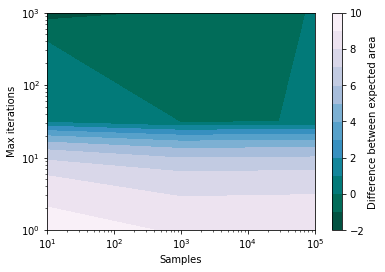

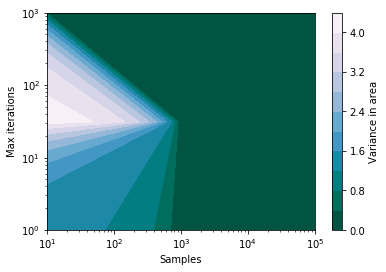

In [12]:
%matplotlib inline

i_list = np.logspace(0, 3, 3, dtype=int)
s_list = np.logspace(1, 5, 3, dtype=int)
plot_i_s_contour(i_list, s_list, log=True)
plot_i_s_variance(i_list, s_list, nruns=3, log=True)

## Error estimation

In [13]:
# Calc i errors
for i in [1, 10, 100, 1000, 10000, 10000]:
    print(f"{i}: {calc_error(i, 1000000):e}")


NameError: name 'calc_error' is not defined

In [ ]:
# Calc s errors
for s in [1, 10, 100, 1000, 10000, 100000]:

    # At low s values the error will have a high variance, therefore we sample 
    # the error multiple times. There is also a error in the i value, which is 
    # substracted from the calculated error.
    errors = []
    for _ in range(100):
        errors.append(abs(calc_error(1000, s)) - 0.0042440000000001366)

    print(f"{s}: {sum(errors) / len(errors):e}")

### i error

|i     |error                |
|------|---------------------|
|1     |8.598812000000002e0  |
|10    |5.164399999999998e-1 |
|100   |3.481999999999963e-2 |
|1000  |4.2440000000001366e-3|
|10000 |5.24000000000191e-4  |

These errors were computed with s=1000000. It is assumed that these are enough samples that the error over s is negligible

### s error

|s     |error       |
|------|------------|
|1     |2.400943e+0 |
|10    |1.011442e+0 |
|100   |2.949779e-1 |
|1000  |1.028386e-1 |
|10000 |2.946552e-2 |
|100000|6.576960e-3 |

These errors were computed with i=1000. The error over i is substracted from these results.

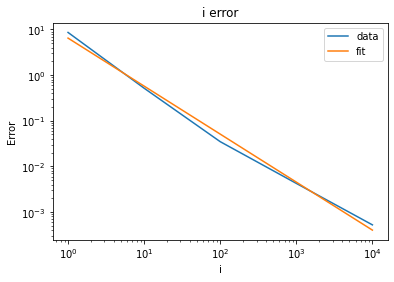

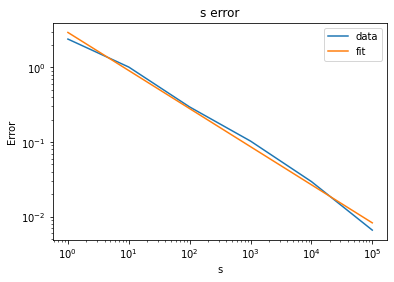

In [ ]:
%matplotlib inline

i_values = [1, 10, 100, 1000, 10000]
i_errors = [8.598812000000002e0, 5.164399999999998e-1, 3.481999999999963e-2, 4.2440000000001366e-3, 5.24000000000191e-4]

s_values = [1, 10, 100, 1000, 10000, 100000]
s_errors = [2.400943e+0, 1.011442e+0, 2.949779e-1, 1.028386e-1, 2.946552e-2, 6.576960e-3]

def linear_function(x, a=1, b=1):
    return a * x + b
    
def exponential_function(x, a=1, c=1):
    return c * x ** a

def inverse_exponential_function(y, a=1, c=1):
    """
    Returns the inverse of the exponential function: y = cx^a.
    """

    return (y / c) ** (1/a)

def calc_error_fit(values, errors):
    """
    This function finds the fit parameters a and c for the function y = cx ^ a. 
    It does this by first taking a linear fit against the logarithmic x and y data. 
    This linear fit is then converted to the logarithmic function.

    https://stackoverflow.com/a/30672483
    """

    popt, pcov = scipy.optimize.curve_fit(linear_function, np.log10(values), np.log10(errors), p0=[1, -1])
    a, b = popt[0], popt[1]

    c = 10 ** b
    return a, c


def plot_error(values, errors, title="", xlabel=""):
    
    a, c = calc_error_fit(values, errors)

    # Compute the fitted values back to expected values
    y_fit_values = [exponential_function(value, a=a, c=c) for value in values]
    
    plt.plot(values, errors, label="data")
    plt.plot(values, y_fit_values, label="fit")

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel(xlabel)
    plt.ylabel("Error")

    plt.title(title)
    plt.legend()
    plt.show()


plot_error(i_values, i_errors, title="i error", xlabel="i")
plot_error(s_values, s_errors, title="s error", xlabel="s")

## Excercise 2

In [ ]:
def plot_j_dependance(i = 25, sample_method="pure"):

    s = get_s_with_comparable_error(i)
    
    area_differences = []
    js = []
    for j in range(1, i):
        js.append(j)
        area_differences.append(determine_area(i=j, s=s, sample_method=sample_method) - EXPECTED_AREA)

    plt.plot(js, area_differences)
    plt.ylabel("Area difference")
    plt.xlabel("j")
    plt.show()

def get_s_with_comparable_error(i):
    """
    Gets a s value, which has comparable error as the error in i.
    """

    # Obtain the fit parameters from the error data in i and s
    i_fit_values = calc_error_fit(i_values, i_errors)
    s_fit_values = calc_error_fit(s_values, s_errors)

    # Get the estimated i error
    i_error = exponential_function(i, a=i_fit_values[0], c=i_fit_values[1])

    # Calculate s from i error
    s = inverse_exponential_function(i_error, a=s_fit_values[0], c=s_fit_values[1])

    return int(s)


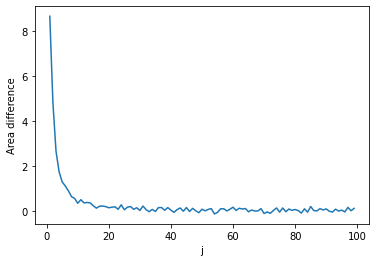

In [ ]:
plot_j_dependance(i=100)

## Quad tree sampling

In [ ]:
class Box():

    def __init__(self, xmin, xmax, ymin, ymax):

        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax

    def calc_area(self):

        return (self.xmax - self.xmin) * (self.ymax - self.ymin)

    def __str__(self):

        return f"{self.xmin}, {self.xmax}, {self.ymin}, {self.ymax}"

def subdivide_box(box):

    xcenter = (box.xmax + box.xmin) / 2
    ycenter = (box.ymax + box.ymin) / 2

    box1 = Box(box.xmin, xcenter, box.ymin, ycenter)
    box2 = Box(xcenter, box.xmax, box.ymin, ycenter)
    box3 = Box(box.xmin, xcenter, ycenter, box.ymax)
    box4 = Box(xcenter, box.xmax, ycenter, box.ymax)

    return (box1, box2, box3, box4)

def quad_tree_area(box, box_area_treshold=0.001, s=100, i=10000):
    """
    Returns:
    area: The mandelbrot area inside the box.
    evals: The number of box evaulations performed to obtain this area.
    """

    if box.calc_area() < box_area_treshold:
        return determine_area(s=s, i=i, xmin=box.xmin, xmax=box.xmax, ymin=box.ymin, ymax=box.ymax, sample_method="pure"), 1

    Z0 = generate_sample_points_pure_random(s, box.xmin, box.xmax, box.ymin, box.ymax)

    Z = Z0

    for _ in range(i):

        Z = np.where(abs(Z) < 2, Z ** 2 + Z0, 100)
        
        # If all points diverge return 0
        if (np.abs(Z) > 2).all():
            return 0, 1

    # if all points points still havent diverged return area of box
    if(np.abs(Z) <  2).all():
        return box.calc_area(), 1

    # At this point in the code the box contains both converge and diverge points.
    # The box is subdived box in 4 smaller boxs from which the area is calculated.

    boxs = subdivide_box(box)
    area = 0
    evals = 0
    for b in boxs:
        results = quad_tree_area(b, box_area_treshold=box_area_treshold, s=s, i=i)
        area += results[0]
        evals += results[1]

    return area, evals

area, evals = quad_tree_area(Box(-2, 2, -2, 2))
print(area, evals)

1.5062402343749999 859


In [ ]:
EXPECTED_AREA

1.506484